In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
# %%bash
!pip install deep_phonemizer

In [17]:
import torch
import torchaudio
torch.random.manual_seed(0)
device="cuda"if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [18]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [19]:
symbols="_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up={s:i for i,s in enumerate(symbols)}
symbols=set(symbols)


In [20]:
def text_to_sequence(text):
    text=text.lower()
    return [look_up[s] for s in text if s in symbols]

In [21]:
text="Hello I'm LLM Large Language Model"
text_to_sequence(text)

[19,
 16,
 23,
 23,
 26,
 11,
 20,
 3,
 24,
 11,
 23,
 23,
 24,
 11,
 23,
 12,
 29,
 18,
 16,
 11,
 23,
 12,
 25,
 18,
 32,
 12,
 18,
 16,
 11,
 24,
 26,
 15,
 16,
 23]

In [22]:
processor=torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
processed,lengths=processor(text)
print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 20,  3, 24, 11, 23, 23, 24, 11, 23, 12, 29, 18,
         16, 11, 23, 12, 25, 18, 32, 12, 18, 16, 11, 24, 26, 15, 16, 23]])
tensor([34], dtype=torch.int32)


In [23]:
print([processor.tokens[i] for i in processed[0,:lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'i', "'", 'm', ' ', 'l', 'l', 'm', ' ', 'l', 'a', 'r', 'g', 'e', ' ', 'l', 'a', 'n', 'g', 'u', 'a', 'g', 'e', ' ', 'm', 'o', 'd', 'e', 'l']


In [24]:
bundle=torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor=bundle.get_text_processor()
text="Hello I'm LLM Large Language Model"
with torch.inference_mode():
    processed,lengths=processor(text)

print(processed)
print(lengths)
    

tensor([[54, 20, 65, 69, 11, 55, 66, 11, 40, 65,  1, 40, 65,  1, 40, 66, 11, 65,
         12, 78, 63, 11, 65, 16, 68, 53, 92, 20, 63, 11, 66, 12, 38, 20, 65]])
tensor([35], dtype=torch.int32)


In [26]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'IH', 'M', ' ', 'EH', 'L', '-', 'EH', 'L', '-', 'EH', 'M', ' ', 'L', 'AA', 'R', 'JH', ' ', 'L', 'AE', 'NG', 'G', 'W', 'AH', 'JH', ' ', 'M', 'AA', 'D', 'AH', 'L']


*Spectrogram generation*

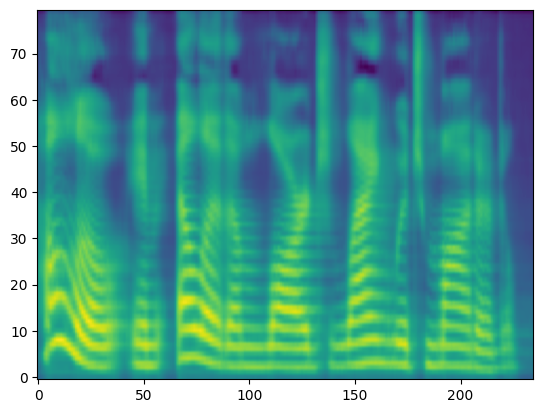

In [29]:
bundle=torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor=bundle.get_text_processor()
tacotron2=bundle.get_tacotron2().to(device)
text="Hello I'm LLM Large Language Model"
with torch.inference_mode():
    processed,lengths=processor(text)
    processed=processed.to(device)
    lengths=lengths.to(device)
    spec,_,_=tacotron2.infer(processed,lengths)
_=plt.imshow(spec[0].cpu().detach(),origin="lower",aspect="auto")    
    

torch.Size([80, 247])
torch.Size([80, 236])
torch.Size([80, 219])


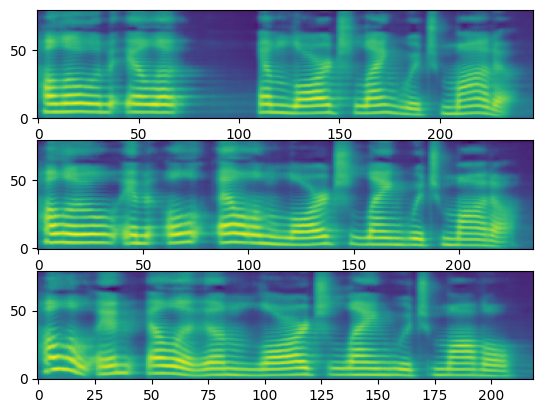

In [30]:
def plot():
    fig,ax=plt.subplots(3,1)
    for i in range(3):
        with torch.inference_mode():
            spec,spec_lengths,_=tacotron2.infer(processed,lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(),origin="lower",aspect="auto")

plot()
        

In [33]:
bundle=torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor=bundle.get_text_processor()
tacotron2=bundle.get_tacotron2().to(device)
vocoder=bundle.get_vocoder().to(device)
text="Hello I'm LLM Large Language Model"

with torch.inference_mode():
    processed,lengths=processor(text)
    processed=processed.to(device)
    lengths=lengths.to(device)
    spec,spec_lengths,_=tacotron2.infer(processed,lengths)
    waveforms,lengths=vocoder(spec,spec_lengths)
    


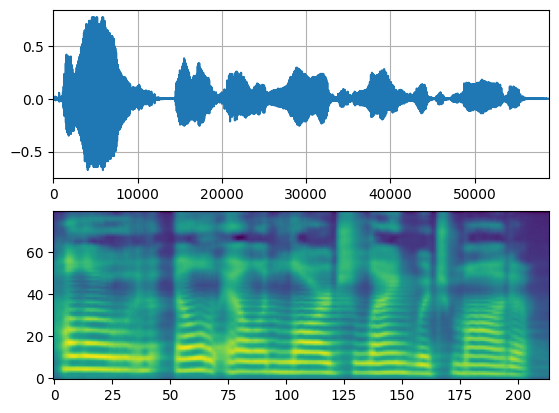

In [34]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

In [35]:
bundle=torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH
processor=bundle.get_text_processor()
tacotron2=bundle.get_tacotron2().to(device)
vocoder=bundle.get_vocoder().to(device)
text="Hello I'm LLM Large Language Model"

with torch.inference_mode():
    processed,lengths=processor(text)
    processed=processed.to(device)
    lengths=lengths.to(device)
    spec,spec_lengths,_=tacotron2.infer(processed,lengths)
    waveforms,lengths=vocoder(spec,spec_lengths)
    


Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth
100%|██████████| 107M/107M [00:00<00:00, 264MB/s] 


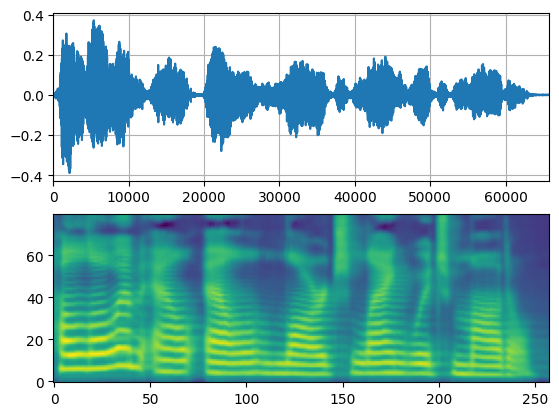

In [37]:
plot(waveforms, spec, vocoder.sample_rate)